Epoch 0, Loss: 0.586015, Physics Loss: 0.568984, Boundary Loss: 0.017031
Epoch 500, Loss: 0.011337, Physics Loss: 0.010601, Boundary Loss: 0.000736
Epoch 1000, Loss: 0.008310, Physics Loss: 0.008269, Boundary Loss: 0.000041
Epoch 1500, Loss: 0.004402, Physics Loss: 0.002461, Boundary Loss: 0.001941
Epoch 2000, Loss: 0.001172, Physics Loss: 0.000620, Boundary Loss: 0.000552
Epoch 2500, Loss: 0.000642, Physics Loss: 0.000195, Boundary Loss: 0.000448
Epoch 3000, Loss: 0.002419, Physics Loss: 0.001032, Boundary Loss: 0.001387
Epoch 3500, Loss: 0.001410, Physics Loss: 0.000611, Boundary Loss: 0.000800
Epoch 4000, Loss: 0.000064, Physics Loss: 0.000047, Boundary Loss: 0.000017
Epoch 4500, Loss: 0.000084, Physics Loss: 0.000079, Boundary Loss: 0.000005


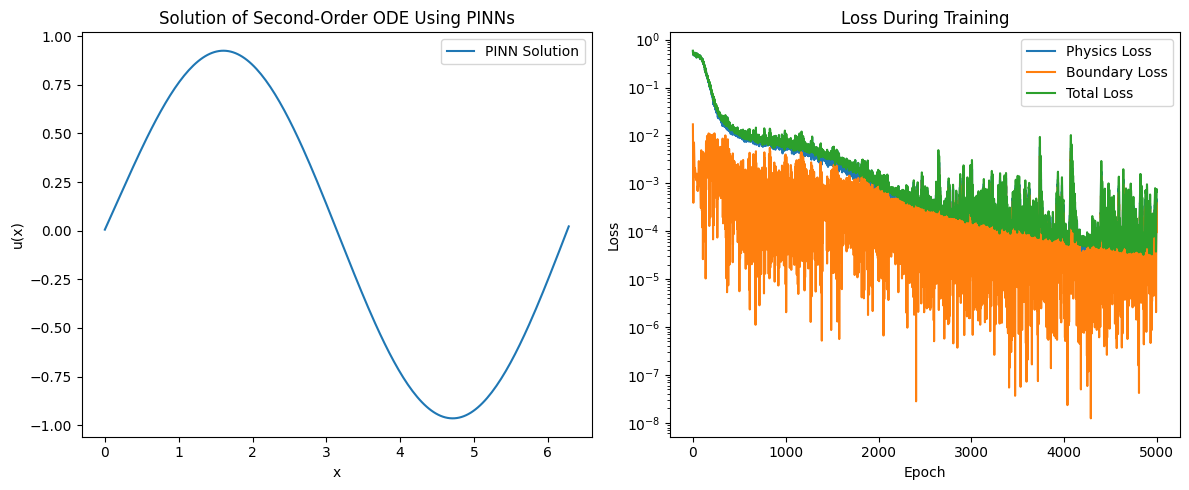

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the forcing term f(x)
def forcing_function(x):
    return torch.cos(x)

# PINN neural network (increased complexity)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Physics-Informed Loss
def physics_loss(model, x):
    # Enable gradients for x
    x.requires_grad = True

    # Predicted u(x)
    u = model(x)

    # Compute u'(x) = du/dx
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

    # Compute u''(x) = d²u/dx²
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]

    # Physics-informed loss: u'' + u' + u = f(x)
    f = forcing_function(x)
    physics_residual = u_xx + u_x + u - f

    # Compute mean squared error of the residual
    return torch.mean(physics_residual**2)

# Boundary Condition Loss
def boundary_loss(model, x_bc, u_bc):
    u_pred = model(x_bc)
    return torch.mean((u_pred - u_bc)**2)

# Training PINN (with adjusted hyperparameters)
def train_pinn(model, optimizer, epochs=6000, num_train_points=256):
    physics_losses = []
    boundary_losses = []
    total_losses = []

    for epoch in range(epochs):
        # Increased number of training points
        x = torch.rand(num_train_points, 1) * 2 * torch.pi  # Sample points between 0 and 2*pi

        # Boundary conditions at x=0 and x=2*pi
        x_bc = torch.tensor([[0.0], [2 * np.pi]]).float()
        u_bc = torch.tensor([[0.0], [0.0]]).float()  # Example: u(0) = 0 and u(2*pi) = 0

        # Compute losses
        p_loss = physics_loss(model, x)
        b_loss = boundary_loss(model, x_bc, u_bc)
        loss = p_loss + b_loss

        # Store losses
        physics_losses.append(p_loss.item())
        boundary_losses.append(b_loss.item())
        total_losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}, Physics Loss: {p_loss.item():.6f}, Boundary Loss: {b_loss.item():.6f}")

    return physics_losses, boundary_losses, total_losses

# Main program
if __name__ == "__main__":
    # Initialize PINN model (more complex network)
    pinn_model = PINN()

    # Optimizer (experiment with different learning rates)
    optimizer = torch.optim.Adam(pinn_model.parameters(), lr=0.0005) # Lowered learning rate

    # Train the model with more epochs and training points
    physics_losses, boundary_losses, total_losses = train_pinn(pinn_model, optimizer, epochs=5000, num_train_points=256)

    # Test the solution
    x_test = torch.linspace(0, 2 * np.pi, 200).reshape(-1, 1)
    u_pred = pinn_model(x_test).detach().numpy()

    # Plotting the solution
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(x_test, u_pred, label="PINN Solution")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.title("Solution of Second-Order ODE Using PINNs")

    # Plotting the losses
    plt.subplot(1, 2, 2)
    epochs_range = range(len(total_losses))
    plt.plot(epochs_range, physics_losses, label="Physics Loss")
    plt.plot(epochs_range, boundary_losses, label="Boundary Loss")
    plt.plot(epochs_range, total_losses, label="Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss During Training")
    plt.yscale('log')
    plt.legend()

    plt.tight_layout()
    plt.show()